In [ ]:
%%capture
!pip -q install --upgrade folium
!apt install libspatialindex-dev
!pip -q install rtree
!pip -q install geopandas
!pip -q install geojson
!pip -q install geemap
!pip -q uninstall tornado -y
!yes | pip install tornado==5.1.0
!pip -q install rasterio
!pip -q install tqdm
!pip -q install eeconvert

In [ ]:
# Standard imports
from tqdm.notebook import tqdm
import requests
import json

import pandas as pd
import numpy as np
from PIL import Image

# Geospatial processing packages
import geopandas as gpd
import geojson

import shapely
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
from shapely.geometry import box

# Mapping and plotting libraries
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import ee
import eeconvert as eec
import geemap
import folium

# Deep learning libraries
import torch
from torchvision import datasets, models, transforms

In [ ]:
!pip install geemap

  Using cached tornado-6.4-cp38-abi3-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (435 kB)
  Attempting uninstall: tornado
    Found existing installation: tornado 5.1
    Uninstalling tornado-5.1:
      Successfully uninstalled tornado-5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires tornado==6.3.3, but you have tornado 6.4 which is incompatible.


In [ ]:
import geemap
import geemap.foliumap as emap
import ee

In [ ]:
## Mount drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
ee.Authenticate()
ee.Initialize(project='ee-myusername1')

4/1AeaYSHC0te3uK8ZGkUXonXwHfkLEcuQQHKQhmqF39Cds9BUeWSyMn8FMnz8

In [ ]:
import requests
import geojson
import geopandas as gpd


https://www.geoboundaries.org/gbRequest.html?ISO=[3-LETTER-ISO-CODE]&ADM=[ADM-LEVEL]

In [ ]:
print(r.text)

NameError: name 'r' is not defined

In [ ]:
import requests

ISO = 'USA'  # ISO code for United States
ADM = 'ADM1'  # Administrative level 1 (states/provinces)

url = f"https://www.geoboundaries.org/api/current/gbOpen/{ISO}/{ADM}"
r = requests.get(url)

if r.status_code == 200:
    boundary_data = r.json()
    # Process the boundary_data as needed
else:
    print("API request failed with status code:", r.status_code)





In [ ]:
if boundary_data and 'gjDownloadURL' in boundary_data:
    dl_path = boundary_data['gjDownloadURL']
    # Proceed to download and process the GeoJSON data
else:
    print("GeoJSON download URL not found in API response")


In [ ]:
filename = 'geoboundary.geojson'
if dl_path:
    geoboundary = requests.get(dl_path).json()
    # Process the downloaded GeoJSON data



In [ ]:
with open(filename, 'w') as file:
   geojson.dump(geoboundary, file)

In [ ]:
# Read data using GeoPandas
geoboundary = gpd.read_file(filename)
print("Data dimensions: {}".format(geoboundary.shape))
geoboundary.sample(3)

Data dimensions: (56, 6)


,shapeName,shapeISO,shapeID,shapeGroup,shapeType,geometry
39,New Jersey,US-NJ,66186276B73434888205604,USA,ADM1,"POLYGON ((-75.41506 39.80193, -75.40542 39.796..."
9,Florida,US-FL,66186276B65591139260314,USA,ADM1,"MULTIPOLYGON (((-80.17628 25.52506, -80.17706 ..."
47,Kentucky,US-KY,66186276B22971435435932,USA,ADM1,"MULTIPOLYGON (((-81.96802 37.53804, -81.96540 ..."


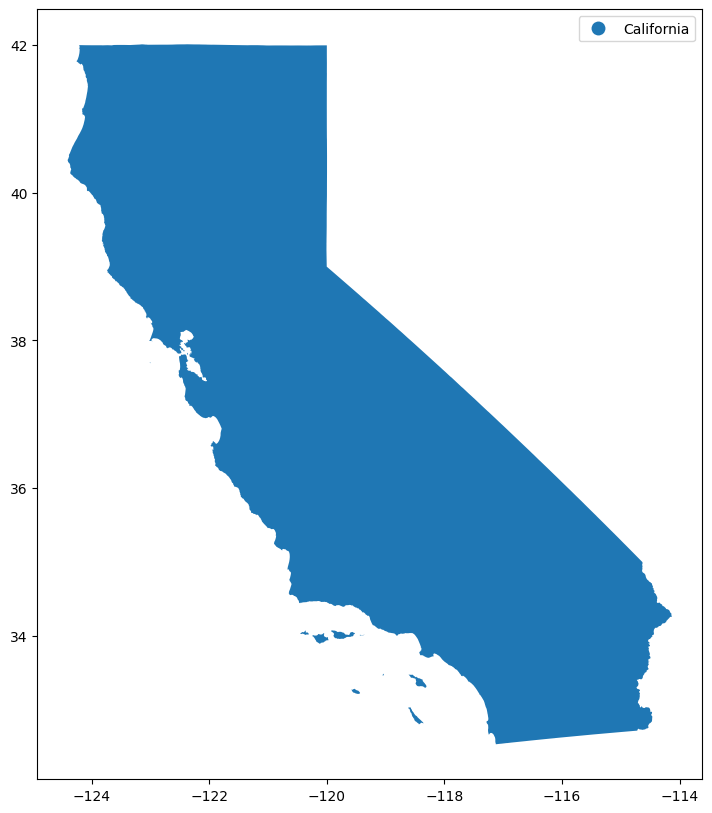

In [ ]:
import matplotlib.pyplot as plt

# Plot GeoDataFrame
shape_name = 'California'
fig, ax = plt.subplots(1, figsize=(10,10))
geoboundary[geoboundary.shapeName == shape_name].plot('shapeName', legend=True, ax=ax);


In [ ]:
def generate_image(
    region,
    product='COPERNICUS/S2',
    min_date='2018-01-01',
    max_date='2020-01-01',
    range_min=0,
    range_max=2000,
    cloud_pct=10
):


    # Generate median aggregated composite
    image = ee.ImageCollection(product)\
        .filterBounds(region)\
        .filterDate(str(min_date), str(max_date))\
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud_pct))\
        .median()

    # Get RGB bands
    image = image.visualize(bands=['B4', 'B3', 'B2'], min=range_min, max=range_max)
    # Note that the max value of the RGB bands is set to 65535
    # because the bands of Sentinel-2 are 16-bit integers
    # with a full numerical range of [0, 65535] (max is 2^16 - 1);
    # however, the actual values are much smaller than the max value.
    # Source: https://stackoverflow.com/a/63912278/4777141

    return image.clip(region)

In [ ]:
import eec  # Import the 'eec' module that contains the gdfToFc function


In [ ]:
import geopandas as gpd
import eeconvert  # Import the 'eec' module

# Assuming 'geoboundary' is a GeoDataFrame containing shape geometries
shape_name = 'California'
region = geoboundary.loc[geoboundary.shapeName == shape_name]
centroid = region.iloc[0].geometry.centroid.coords[0]

# Convert GeoDataFrame to feature collection using eec.gdfToFc
region = eeconvert.gdfToFc(region)

# Generate RGB image using GEE (assuming 'generate_image' function is defined)
image = generate_image(
    region,
    product='COPERNICUS/S2',
    min_date='2021-01-01',
    max_date='2021-12-31',
    cloud_pct=10
)

# Visualize map using emap (assuming 'emap.Map' is defined)
Map = emap.Map(center=[centroid[1], centroid[0]], zoom=10)
Map.addLayer(image, {}, 'Sentinel2')
Map.addLayerControl()
Map


In [ ]:
!pip install eeconvert


In [ ]:
import eeconvert


In [ ]:
def export_image(image, filename, region, folder):

    print('Exporting to {}.tif ...'.format(filename))

    task = ee.batch.Export.image.toDrive(
      image=image,
      driveFolder=folder,
      scale=10,
      region=region.geometry(),
      description=filename,
      fileFormat='GeoTIFF',
      crs='EPSG:4326',
      maxPixels=15000000000
    )
    task.start()

    return task

In [ ]:
folder = 'Colab Notebooks'
task = export_image(image, shape_name, region, folder)

Exporting to California.tif ...


In [ ]:
task.status()

{'state': 'RUNNING',
 'description': 'California',
 'priority': 100,
 'creation_timestamp_ms': 1714243215483,
 'update_timestamp_ms': 1714243225251,
 'start_timestamp_ms': 1714243221514,
 'task_type': 'EXPORT_IMAGE',
 'attempt': 1,
 'id': 'DLRECVABYQPSE4U7YGLRKJJ6',
 'name': 'projects/ee-myusername1/operations/DLRECVABYQPSE4U7YGLRKJJ6'}

In [ ]:
import datetime

# Convert milliseconds to seconds
start_time = 1714236302403 / 1000  # Convert start timestamp to seconds
update_time = 1714238044196 / 1000  # Convert update timestamp to seconds

# Calculate elapsed time in seconds
elapsed_time_seconds = update_time - start_time

# Display the elapsed time in a readable format
elapsed_time = datetime.timedelta(seconds=elapsed_time_seconds)

print("Elapsed time: {}".format(elapsed_time))


Elapsed time: 0:29:01.793000


In [ ]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.plot import show

# Mount Google Drive (if not already mounted)
from google.colab import drive
drive.mount('/content/drive')

# Define the base directory where the GeoTIFF files are located
base_dir = '/content/drive/My Drive/Colab Notebooks/'

# Function to filter files by name pattern
def find_matching_files(directory, prefix, suffix):
    files = []
    for filename in os.listdir(directory):
        if filename.startswith(prefix) and filename.endswith(suffix):
            files.append(os.path.join(directory, filename))
    return files

try:
    # Find all files matching the pattern 'California*.tif' in the base directory
    matching_files = find_matching_files(base_dir, 'California', '.tif')

    if matching_files:
        tif_file = matching_files[0]                                            # not working

        # Open the GeoTIFF image using Rasterio
        image = rio.open(tif_file)

        # Filter the geoboundary GeoDataFrame to extract the geometry for California
        california_geometry = geoboundary[geoboundary['shapeName'] == 'California'].geometry.iloc[0]

        # Plot the image and corresponding boundary for California
        fig, ax = plt.subplots(figsize=(15, 15))
        gpd.GeoSeries(california_geometry).plot(facecolor="none", edgecolor='red', ax=ax)
        show(image, ax=ax, title='California')  # Display image with title as 'California'

        plt.show()  # Show the plot for California
    else:
        print("No matching GeoTIFF file found for California.")
except Exception as e:
    print(f"Error loading image for California: {str(e)}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install rasterio


In [ ]:
import rasterio as rio
from rasterio.plot import show


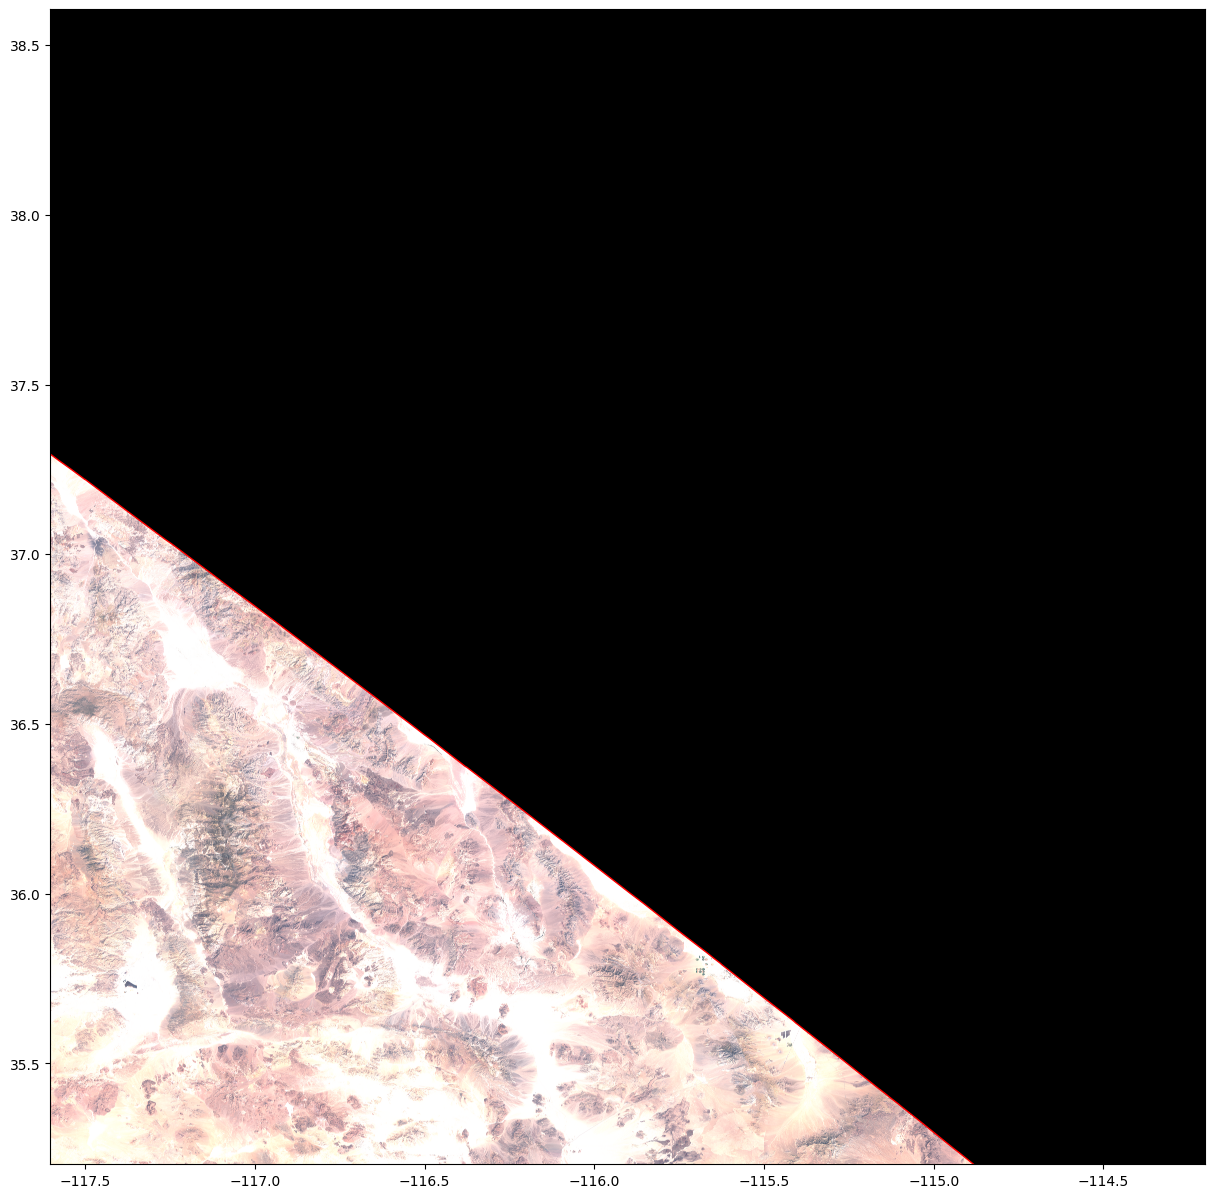

In [ ]:
cwd = './drive/My Drive/Colab Notebooks/'
tif_file = cwd + '{}.tif'.format(shape_name)

# Open image file using Rasterio
image = rio.open(tif_file)
boundary = geoboundary[geoboundary.shapeName == shape_name]

# Plot image and corresponding boundary
fig, ax = plt.subplots(figsize=(15,15))
boundary.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);

In [ ]:
## Generate 64*64 pix GeoJSON Tiles

def generate_tiles(image_file, output_file, area_str, size=64):


    # Open the raster image using rasterio
    raster = rio.open(image_file)
    width, height = raster.shape

    # Later convert this dict into a GeoPandas DataFrame.
    geo_dict = { 'id' : [], 'geometry' : []}
    index = 0

    #sliding window across the raster image
    with tqdm(total=width*height) as pbar:
      for w in range(0, width, size):
          for h in range(0, height, size):

              window = rio.windows.Window(h, w, size, size)
              # Get the georeferenced window bounds
              bbox = rio.windows.bounds(window, raster.transform)
              # Create a shapely geometry from the bounding box
              bbox = box(*bbox)

              # Create a unique id for each geometry
              uid = '{}-{}'.format(area_str.lower().replace(' ', '_'), index)

              # Update dictionary
              geo_dict['id'].append(uid)
              geo_dict['geometry'].append(bbox)

              index += 1
              pbar.update(size*size)

    # Cast dictionary as a GeoPandas DataFrame
    results = gpd.GeoDataFrame(pd.DataFrame(geo_dict))
    # Set CRS to EPSG:4326
    results.crs = {'init' :'epsg:4326'}
    # Save file as GeoJSON
    results.to_file(output_file, driver="GeoJSON")

    raster.close()
    return results

In [ ]:
output_file = cwd+'{}.geojson'.format(shape_name)
tiles = generate_tiles(tif_file, output_file, shape_name, size=64)
print('Data dimensions: {}'.format(tiles.shape))
tiles.head(3)

  0%|          | 0/1435500544 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Data dimensions: (350464, 2)


,id,geometry
0,california-0,"POLYGON ((-117.59684 38.60025, -117.59684 38.6..."
1,california-1,"POLYGON ((-117.59109 38.60025, -117.59109 38.6..."
2,california-2,"POLYGON ((-117.58534 38.60025, -117.58534 38.6..."


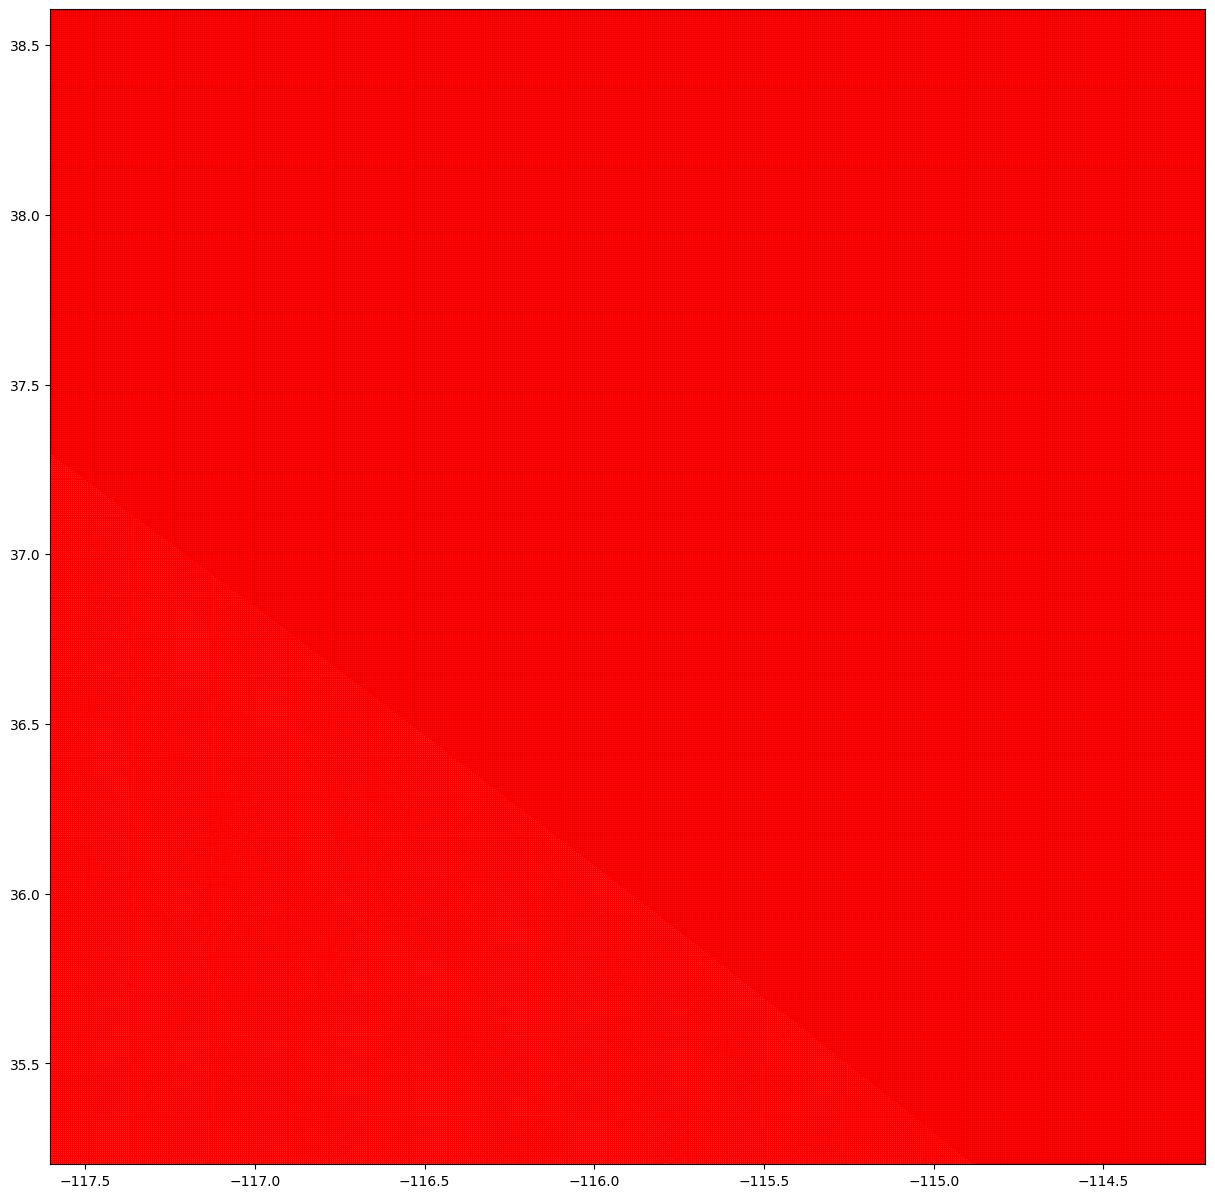

In [ ]:
## Visualize 64*64 pix tiles

image = rio.open(tif_file)
fig, ax = plt.subplots(figsize=(15,15))
tiles.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-23-bf805cd971f2>:4: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  tiles = gpd.sjoin(tiles, boundary, op='within')


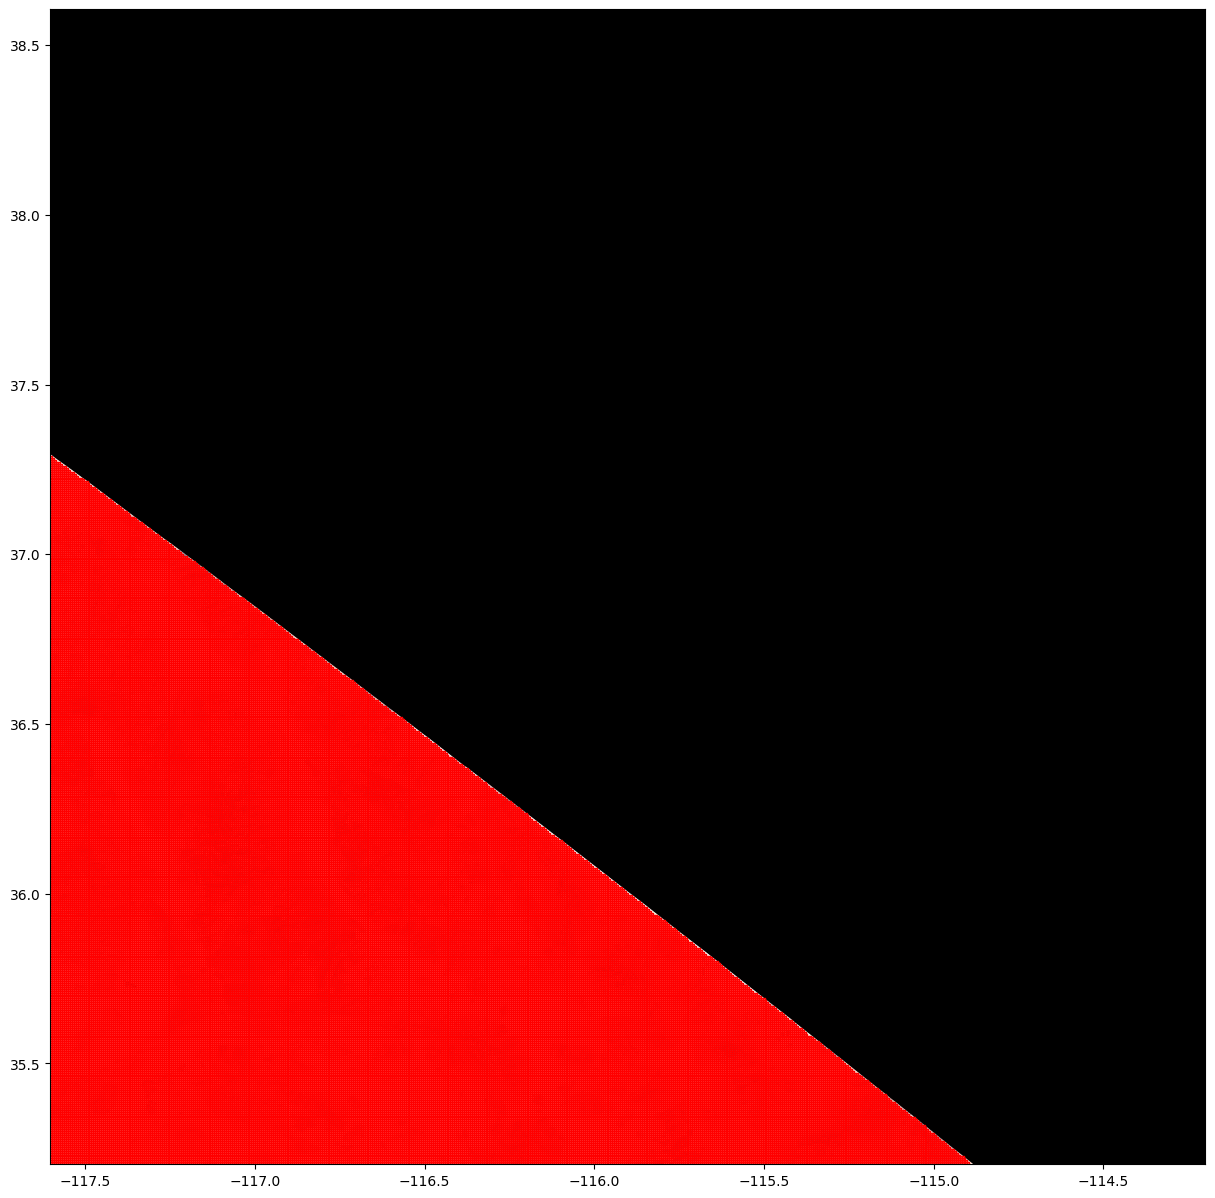

In [ ]:
image = rio.open(tif_file)

# Geopandas sjoin function
tiles = gpd.sjoin(tiles, boundary, op='within')

fig, ax = plt.subplots(figsize=(15,15))
tiles.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);

In [ ]:
## Generate Alnd use and Land cover Map

# LULC Classes
classes = [
  'AnnualCrop',
  'Forest',
  'HerbaceousVegetation',
  'Highway',
  'Industrial',
  'Pasture',
  'PermanentCrop',
  'Residential',
  'River',
  'SeaLake'
]

In [ ]:
# Load Eurosat Model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_file = cwd+'/models/best_model.pth'

model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model.load_state_dict(torch.load(model_file, map_location=device))
model.eval()

print('Model file {} successfully loaded.'.format(model_file))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 150MB/s]


Model file ./drive/My Drive/Colab Notebooks//models/best_model.pth successfully loaded.


In [ ]:
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

In [ ]:
## model prediction and LULc map generation

def predict_crop(image, shape, classes, model, show=False):


    with rio.open(image) as src:
        out_image, out_transform = rio.mask.mask(src, shape, crop=True)
        # Crop out black (zero) border
        _, x_nonzero, y_nonzero = np.nonzero(out_image)
        out_image = out_image[
          :,
          np.min(x_nonzero):np.max(x_nonzero),
          np.min(y_nonzero):np.max(y_nonzero)
        ]
        out_meta = src.meta
        out_meta.update({
              "driver": "GTiff",
              "height": out_image.shape[1],
              "width": out_image.shape[2],
              "transform": out_transform
        })

        # Save the cropped image as a temporary TIFF file.
        temp_tif = './drive/My Drive/Colab Notebooks/temp.tif'
        with rasterio.open(temp_tif, "w", **out_meta) as dest:
          dest.write(out_image)


        image = Image.open(temp_tif)
        input = transform(image)
        output = model(input.unsqueeze(0))
        _, pred = torch.max(output, 1)
        label = str(classes[int(pred[0])])

        if show:
          out_image.show(title=label)

        return label

    return None

In [ ]:
# Commence model prediction
labels = []
for index in tqdm(range(len(tiles)), total=len(tiles)):
  label = predict_crop(tif_file, [tiles.iloc[index]['geometry']], classes, model)
  labels.append(label)
tiles['pred'] = labels

# Cleanup temporary files
!rm './drive/My Drive/Colab Notebooks/temp.tif'

# Save predictions
filepath = cwd + "{}_preds.geojson".format(shape_name)
tiles.to_file(filepath, driver="GeoJSON")

tiles.head(3)

  0%|          | 0/86879 [00:00<?, ?it/s]

,id,geometry,index_right,shapeName,shapeISO,shapeID,shapeGroup,shapeType,pred
135568,california-135568,"POLYGON ((-117.59684 37.28368, -117.59684 37.2...",16,California,US-CA,66186276B43071933723331,USA,ADM1,AnnualCrop
136160,california-136160,"POLYGON ((-117.59684 37.27793, -117.59684 37.2...",16,California,US-CA,66186276B43071933723331,USA,ADM1,PermanentCrop
136161,california-136161,"POLYGON ((-117.59109 37.27793, -117.59109 37.2...",16,California,US-CA,66186276B43071933723331,USA,ADM1,AnnualCrop


In [ ]:
## Visulalize interactive LULC Map

filepath = cwd + "{}_preds.geojson".format(shape_name)
tiles = gpd.read_file(filepath)
tiles.head(3)

,id,index_right,shapeName,shapeISO,shapeID,shapeGroup,shapeType,pred,geometry
0,california-135568,16,California,US-CA,66186276B43071933723331,USA,ADM1,AnnualCrop,"POLYGON ((-117.59684 37.28368, -117.59684 37.2..."
1,california-136160,16,California,US-CA,66186276B43071933723331,USA,ADM1,PermanentCrop,"POLYGON ((-117.59684 37.27793, -117.59684 37.2..."
2,california-136161,16,California,US-CA,66186276B43071933723331,USA,ADM1,AnnualCrop,"POLYGON ((-117.59109 37.27793, -117.59109 37.2..."


In [ ]:

colors = {
  'AnnualCrop' : 'lightgreen',
  'Forest' : 'forestgreen',
  'HerbaceousVegetation' : 'yellowgreen',
  'Highway' : 'gray',
  'Industrial' : 'red',
  'Pasture' : 'mediumseagreen',
  'PermanentCrop' : 'chartreuse',
  'Residential' : 'magenta',
  'River' : 'dodgerblue',
  'SeaLake' : 'blue'
}
tiles['color'] = tiles["pred"].apply(
  lambda x: cl.to_hex(colors.get(x))
)
tiles.head(10)

,id,index_right,shapeName,shapeISO,shapeID,shapeGroup,shapeType,pred,geometry,color
0,california-135568,16,California,US-CA,66186276B43071933723331,USA,ADM1,AnnualCrop,"POLYGON ((-117.59684 37.28368, -117.59684 37.2...",#90ee90
1,california-136160,16,California,US-CA,66186276B43071933723331,USA,ADM1,PermanentCrop,"POLYGON ((-117.59684 37.27793, -117.59684 37.2...",#7fff00
2,california-136161,16,California,US-CA,66186276B43071933723331,USA,ADM1,AnnualCrop,"POLYGON ((-117.59109 37.27793, -117.59109 37.2...",#90ee90
3,california-136752,16,California,US-CA,66186276B43071933723331,USA,ADM1,AnnualCrop,"POLYGON ((-117.59684 37.27218, -117.59684 37.2...",#90ee90
4,california-136753,16,California,US-CA,66186276B43071933723331,USA,ADM1,AnnualCrop,"POLYGON ((-117.59109 37.27218, -117.59109 37.2...",#90ee90
5,california-136754,16,California,US-CA,66186276B43071933723331,USA,ADM1,AnnualCrop,"POLYGON ((-117.58534 37.27218, -117.58534 37.2...",#90ee90
6,california-137344,16,California,US-CA,66186276B43071933723331,USA,ADM1,AnnualCrop,"POLYGON ((-117.59684 37.26643, -117.59684 37.2...",#90ee90
7,california-137345,16,California,US-CA,66186276B43071933723331,USA,ADM1,AnnualCrop,"POLYGON ((-117.59109 37.26643, -117.59109 37.2...",#90ee90
8,california-137346,16,California,US-CA,66186276B43071933723331,USA,ADM1,AnnualCrop,"POLYGON ((-117.58534 37.26643, -117.58534 37.2...",#90ee90
9,california-137347,16,California,US-CA,66186276B43071933723331,USA,ADM1,AnnualCrop,"POLYGON ((-117.57959 37.26643, -117.57959 37.2...",#90ee90


In [ ]:
import folium

# (centroid of California)
center_lat, center_lon = 36.7783, -119.4179  # Coordinates of California's centroid

# Instantiate a map centered on California
map = folium.Map(location=[center_lat, center_lon], zoom_start=7)

# Load and add the LULC GeoJSON data for California
california_geojson = "drive/notebooks/California.geojson"
folium.GeoJson(
    california_geojson,
    style_function=lambda feature: {
        'fillColor': feature['properties']['color'],
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.5
    },
    name='California LULC Map'
).add_to(map)

# Google Satellite basemap
folium.TileLayer(
    tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
    attr='Google',
    name='Google Satellite',
    overlay=True,
    control=True
).add_to(map)

# Display the map with layer control
folium.LayerControl().add_to(map)

# Show map
map


FileNotFoundError: [Errno 2] No such file or directory: 'path_to_california_geojson.geojson'

In [ ]:
import folium
import geopandas as gpd
import matplotlib.colors as cl

# Specify the center of the map (centroid of California)
center_lat, center_lon = 36.7783, -119.4179  # Coordinates of California's centroid

# Instantiate a map centered on California
map = folium.Map(location=[center_lat, center_lon], zoom_start=7)

# Define colors for each land cover class
colors = {
    'AnnualCrop': 'lightgreen',
    'Forest': 'forestgreen',
    'HerbaceousVegetation': 'yellowgreen',
    'Highway': 'gray',
    'Industrial': 'red',
    'Pasture': 'mediumseagreen',
    'PermanentCrop': 'chartreuse',
    'Residential': 'magenta',
    'River': 'dodgerblue',
    'SeaLake': 'blue'
}

# Add LULC GeoJSON data with colored polygons based on predicted classes
for idx, row in tiles.iterrows():
    color = colors.get(row['pred'], 'gray')  # Default to gray if color not found
    folium.GeoJson(
        row['geometry'],
        style_function=lambda feature, color=color: {
            'fillColor': color,
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.7
        },
        tooltip=row['pred']  # Display land cover class as tooltip
    ).add_to(map)

# Add a layer control to toggle visibility of different layers
folium.LayerControl().add_to(map)

# Display the map
map
